In [1]:
# run in the root of the repository
%load_ext autoreload
%autoreload 2
 
%cd ../..

/private/home/pfz/09-videoseal/videoseal-dev


In [2]:
from videoseal.utils.display import save_img
from videoseal.utils import Timer
from videoseal.evals.full import setup_model_from_checkpoint
from videoseal.evals.metrics import bit_accuracy, psnr, ssim
from videoseal.augmentation import Identity, JPEG
from videoseal.modules.jnd import JND, VarianceBasedJND


import os
import omegaconf
from tqdm import tqdm
import gc
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision

to_tensor = torchvision.transforms.ToTensor()
to_pil = torchvision.transforms.ToPILImage()

device = "cpu" 

/private/home/pfz/miniconda3/envs/img/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/private/home/pfz/miniconda3/envs/img/lib/python3.13/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


### Base model inference

Model loaded successfully from /checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth with message: <All keys matched successfully>
{'file': '/private/home/pfz/_images/tahiti.png', 'bit_accuracy': 1.0, 'psnr': 47.380374908447266, 'ssim': 0.9984626770019531}


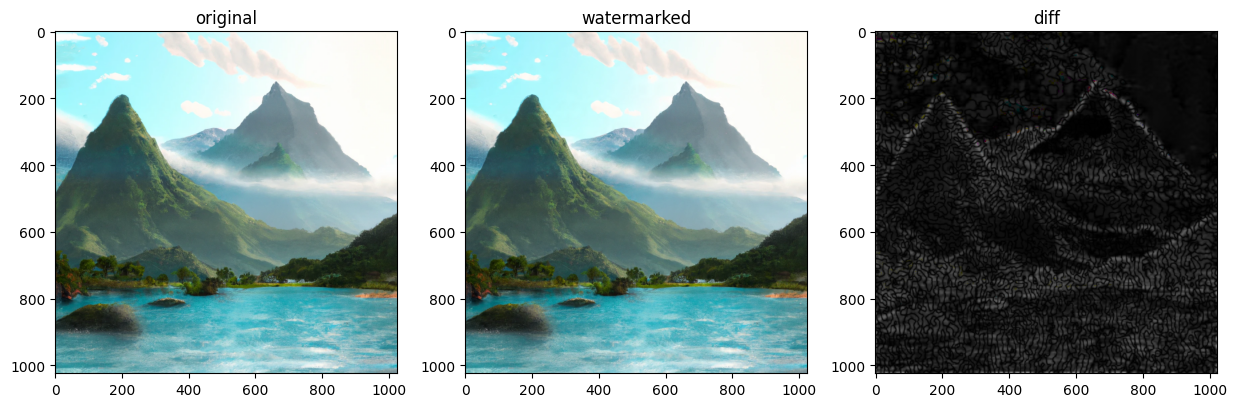

In [3]:
# Directory containing videos
num_imgs = 10
assets_dir = "assets/imgs"
base_output_dir = "outputs"
os.makedirs(base_output_dir, exist_ok=True)

ckpt = "/checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth"
wam = setup_model_from_checkpoint(ckpt)
wam.blender.scaling_w = 0.2
wam.eval()
wam.to(device)
    
# wam.compile()

# Iterate over all video files in the directory
file = "/private/home/pfz/_images/tahiti.png"
imgs = Image.open(file, "r").convert("RGB")  # keep only rgb channels
imgs = to_tensor(imgs).unsqueeze(0).float()

# Watermark em
outputs = wam.embed(imgs, is_video=False, lowres_attenuation=True)
torch.cuda.synchronize()
# print(f"embedding watermark  - took {timer.stop():.2f}s")

# compute diff
imgs_w = outputs["imgs_w"]  # b c h w
msgs = outputs["msgs"]  # b k
diff = (imgs_w - imgs).abs() * 25

# save
imgs_aug = imgs_w
outputs = wam.detect(imgs_aug, is_video=False)
preds = outputs["preds"]
metrics = {
    "file": file,
    "bit_accuracy": bit_accuracy(
        outputs["preds"][:, 1:],
        msgs
    ).nanmean().item(),
    "psnr": psnr(imgs_w, imgs).item(),
    "ssim": ssim(imgs_w, imgs).item()
}

# Augment video
# print(f"compressing and detecting watermarks")
# for qf in [80, 40]:
#     imgs_aug, _ = JPEG()(imgs_w, None,qf)

#     outputs = wam.detect(imgs_aug, is_video=True)
#     preds = outputs["preds"]
#     # print(preds)
#     bit_preds = preds[:, 1:]  # b k ...
#     bit_accuracy_ = bit_accuracy(
#         bit_preds,
#         msgs
#     ).nanmean().item()
    
#     metrics[f"bit_accuracy_qf{qf}"] = bit_accuracy_

print(metrics)

# plot img, imgs_w, diff
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(imgs.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("original")
plt.subplot(1, 3, 2)
plt.imshow(imgs_w.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("watermarked")
plt.subplot(1, 3, 3)
plt.imshow(diff.squeeze(0).permute(1, 2, 0).cpu().numpy())
plt.title("diff")
plt.show()

### Trace

In [4]:
# create trace for embedder

class EmbedderWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, imgs, msgs):
        return self.model.embed(imgs, msgs, is_video=False, lowres_attenuation=True)["imgs_w"]

In [5]:
embedder_tr = EmbedderWrapper(wam)
embedder_tr.eval()

embedder_tr = torch.jit.trace(embedder_tr, (imgs, msgs))
torch.jit.save(embedder_tr, "outputs/embedder.pt")

/private/home/pfz/09-videoseal/videoseal-dev/videoseal/models/wam.py:162: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if imgs.shape[-2:] != (self.img_size, self.img_size):
/private/home/pfz/09-videoseal/videoseal-dev/videoseal/modules/unet.py:224: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  nb_imgs: int = len(imgs)
/private/home/pfz/09-videoseal/videoseal-dev/videoseal/modules/msg_processor.py:107: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently

In [6]:
# print size
print(f"Size of the model: {os.path.getsize(ckpt) / 1e6:.2f} MB")
print(f"Size of the model: {os.path.getsize('outputs/embedder.pt') / 1e6:.2f} MB")

# load 
# num params in embedder
print(f"Number of parameters in embedder: {sum(p.numel() for p in wam.embedder.parameters())/ 1024 / 1024} ")

embedder_tr = torch.jit.load("outputs/embedder.pt")
imgs_w_tr = embedder_tr(imgs, msgs)

# check that the output is the same
diff = (imgs_w - imgs_w_tr).abs()
print(f"diff: {diff.mean().item()}")


Size of the model: 686.84 MB
Size of the model: 228.81 MB
Number of parameters in embedder: 22.56428623199463 
diff: 0.0


### Torchscript


In [5]:
device = "cpu"
ckpt = "/checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth"
wam = setup_model_from_checkpoint(ckpt)
wam.blender.scaling_w = 0.2
wam.eval()
wam.to(device)

from videoseal.models.wam_jit import WamJIT

model_jit = WamJIT(wam.embedder, wam.detector, wam.attenuation, 0.2, 1.0)
model_jit.eval()
model_jit = torch.jit.script(model_jit)
model_jit.save("outputs/y_256b_img.jit")
print(f"Saved model to outputs/y_256b_img.jit")
print(f"Size of the model: {os.path.getsize('outputs/y_256b_img.jit') / 1e6:.2f} MB")

# test 
model_jit = torch.jit.load("outputs/y_256b_img.jit")
imgs_w_jit, preds = model_jit(imgs, msgs)
diff = (imgs_w - imgs_w_jit).abs()
print(f"diff: {diff.mean().item()}")

Model loaded successfully from /checkpoint/pfz/2025_logs/0306_vseal_ydisc_release_bis/_nbits=256/checkpoint600.pth with message: <All keys matched successfully>
Saved model to outputs/y_256b_img.jit
Size of the model: 228.52 MB
diff: 0.0


In [7]:
!wget https://dl.fbaipublicfiles.com/videoseal/y_256b_img.jit -P ckpts/

--2025-03-19 16:40:07--  https://dl.fbaipublicfiles.com/videoseal/y_256b_img.jit
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 

18.238.176.126, 18.238.176.115, 18.238.176.44, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.238.176.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228517509 (218M) [binary/octet-stream]
Saving to: ‘ckpts/y_256b_img.jit’

y_256b_img.jit      100%[===================>] 217.93M  30.7MB/s    in 6.9s    

2025-03-19 16:40:15 (31.6 MB/s) - ‘ckpts/y_256b_img.jit’ saved [228517509/228517509]



In [3]:
import torch
from PIL import Image
from torchvision.transforms.functional import to_tensor, to_pil_image

# Load the JIT model.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load("ckpts/y_256b_img.jit")
model.to(device)
model.eval()

# Load image.
img_path = "/private/home/pfz/_images/tahiti.png"
img = Image.open(img_path).convert("RGB")
img_o = to_tensor(img).unsqueeze(0).float().to(device)

# Create a message to embed (random binary vector of 256bits).
msg = torch.randint(0, 2, (1, 256)).float().to(device)

# Option 1: Combined embedding and detection.
with torch.no_grad():
    # Returns watermarked image and predictions.
    img_w, preds = model(img_o, msg)

# Option 2: Embedding only.
with torch.no_grad():
    # Returns watermarked image directly.
    img_w = model.embed(img_o, msg)

# Convert back to PIL Image for saving.
img_w_pil = to_pil_image(img_w.squeeze().cpu())
save_path = img_path.split(".")[0] + "_wm.jpg"
img_w_pil.save(save_path)

# Option 3: Detection only.
img_w = Image.open(save_path).convert("RGB")
img_w = to_tensor(img_w).unsqueeze(0).float().to(device)
with torch.no_grad():
    # Returns predictions tensor directly.
    preds = model.detect(img_w)
    
    # Process predictions to get binary message.
    # Assuming first channel is detection mask and rest are bit predictions.
    bit_preds = preds[:, 1:]  # Exclude mask
    detected_message = (bit_preds > 0).float()  # Threshold


In [6]:
import torchvision
import videoseal
from videoseal.evals.metrics import bit_accuracy

# Load video and normalize to [0, 1]
video_path = "assets/videos/1.mp4"
video = torchvision.io.read_video(video_path, output_format="TCHW")[0]
video = (video.float() / 255.0).to(device)[:16] # Take first 16 frames to avoid OOM
msgs = torch.randint(0, 2, (1, 256)).float().to(device)

# Video watermarking
video_w = model.embed(video, msgs, is_video=True) # this will embed a random msg

# Extract the watermark message
msg_extracted = model.detect(video_w, is_video=True)

# VideoSeal can do image Watermarking
img = video[0:1] # 1 x C x H x W
img_w = model.embed(img, msgs, is_video=False)
msg_extracted = model.detect(img_w, is_video=False)

In [ ]:
import os
from PIL import Image
import torch
from torchvision.transforms.functional import to_tensor, to_pil_image

# Download the model and load it.
os.makedirs("ckpts", exist_ok=True)
if not os.path.exists("ckpts/y_256b_img.jit"):
    os.system("wget https://dl.fbaipublicfiles.com/videoseal/y_256b_img.jit -P ckpts/")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.jit.load("ckpts/y_256b_img.jit").to(device).eval()

# Image watermarking in 4 lines.
img = to_tensor(Image.open("/private/home/pfz/_images/tahiti.png")).unsqueeze(0).float().to(device)
msg = torch.randint(0, 2, (1, 256)).float().to(device)
img_watermarked = model.embed(img, msg)
preds = model.detect(img_watermarked)

# Metrics.
print(f"L2: {((img_watermarked - img)**2).mean().item():.2e}")
print(f"bit_acc: {((preds[:, 1:] > 0).float() == msg).float().mean().item():.2f}")
to_pil_image(img_watermarked.squeeze().cpu()).save("output_wm.png")

L2: 1.88e-05
bit_acc: 1.00
